In [1]:
import os
import glob
import re
import pandas as pd
import shutil
import zipfile
import geopandas as gpd
import requests
import json
import numpy as np
import _config

In [18]:
df_projects                     = _config.df_projects
tdm_model                       = _config.tdm_model
tdm_transit_scenario            = _config.tdm_transit_scenario
input_model_line_files_folder   = _config.input_model_line_files_folder
input_tdm_link_shapefile_folder = _config.input_tdm_link_shapefile_folder
tdm_link_shapefile              = _config.tdm_link_shapefile
tdm_node_shapefile              = _config.tdm_node_shapefile
input_tdm_node_shapefile_folder = _config.input_tdm_node_shapefile_folder
df_centers                      = _config.df_centers
input_taz_shapefile_folder      = _config.input_taz_shapefile_folder
taz_shapefile                   = _config.taz_shapefile
df_center_override              = _config.df_center_override

# Intersect Centers with TAZ

In [33]:
df_centers

,center_type,FAR,bldg_size,size_of_hh_units,sf_per_employee,units_per_acre,sf_per_acre,%_residential,%_non_res,"gross_to_net_conversion_(streets,_etc)",final_units_per_acre,final_emps_per_acre,application_area,application_area_miles,household_size,office_retail_split
0,Neighborhood Center,0.6,26136,1000,500,26.136,52.27,0.85,0.15,0.8,18,6,1/8 mile radius,0.125,1.62,20/80
1,City Center,1.13,49222.8,850,450,57.909176,109.38,0.85,0.15,0.8,39,13,990 foot radius,0.1875,1.62,30/70
2,Urban Center,1.5,65340,750,400,87.12,163.35,0.85,0.15,0.8,59,20,1/4 mile radius,0.25,1.62,40/60
3,Metropolitan Center,2.0,86734,650,350,133.43,247.81,0.85,0.15,0.8,91,30,1/3 mile radius,0.3333,1.62,50/50


,OBJECTID,AreaName,AreaType,Area,Shape__Area,Shape__Length,geometry
3,28,Canyons,Neighborhood Center,Summit County,4.571034e+05,2580.425872,"POLYGON ((452906.669 4504138.938, 453337.539 4..."
4,35,Crossroads,City Center,Utah County,3.847764e+06,8225.990373,"POLYGON ((421588.154 4469656.985, 421588.155 4..."
5,39,Deer Valley Base,Neighborhood Center,Summit County,1.626199e+05,2318.218626,"POLYGON ((459498.130 4499177.318, 459512.730 4..."
7,43,Downtown Provo,Urban Center,Utah County,1.267076e+07,30147.565078,"POLYGON ((444202.107 4456362.513, 444206.567 4..."
8,46,Downtown Springville,City Center,Utah County,2.891819e+06,13102.452873,"POLYGON ((445119.776 4446055.292, 447868.307 4..."
...,...,...,...,...,...,...,...
296,511,Cottonwood Village,Neighborhood Center,WFRC MPO,1.275807e+05,1603.672031,"POLYGON ((428976.795 4502431.078, 428978.502 4..."
297,512,Independence,City Center,WFRC MPO,5.686543e+06,11136.244285,"POLYGON ((420920.227 4479707.977, 420935.444 4..."
298,513,Porter Rockwell,Urban Center,WFRC MPO,4.110667e+06,10191.341842,"POLYGON ((423145.110 4480905.812, 423142.073 4..."
299,514,Washington Terrace US 89,City Center,WFRC MPO,1.478004e+06,7268.026224,"POLYGON ((418306.763 4557002.282, 418306.874 4..."


<AxesSubplot:>

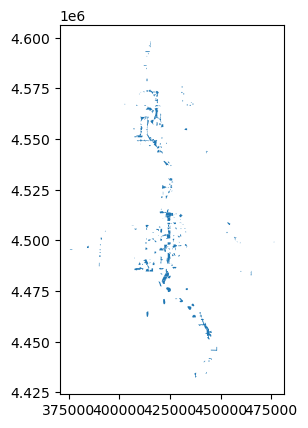

In [80]:
# read in wasatch choice center dataset and convert to UTM Zone 12N
gdf_wc_centers = gpd.read_file('input/wasatch-choice-centers/wc-centers.geojson')
gdf_wc_centers = gdf_wc_centers.to_crs(26912)

# filter for area types 
# Get the unique center types from df_centers
center_types = df_centers['center_type'].unique()

# Filter gdf_wc_centers based on the center types
gdf_filtered_centers = gdf_wc_centers[gdf_wc_centers['AreaType'].isin(center_types)]

display(gdf_filtered_centers)
display(gdf_filtered_centers.plot())

In [40]:
gdf_filtered_centers.groupby(['AreaType']).count()

,OBJECTID,AreaName,Area,Shape__Area,Shape__Length,geometry
AreaType,,,,,,
City Center,90,90,90,90,90,90
Metropolitan Center,2,2,2,2,2,2
Neighborhood Center,112,112,112,112,112,112
Urban Center,22,22,22,22,22,22


<AxesSubplot:>

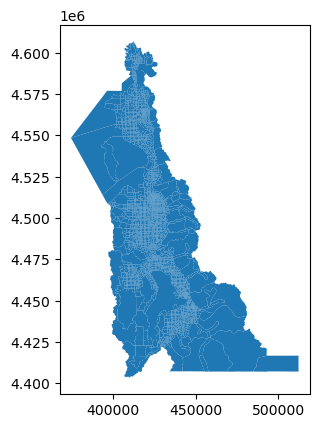

In [37]:
# import taz shapefile
gdf_taz = gpd.read_file(os.path.join(input_taz_shapefile_folder, taz_shapefile))
gdf_taz.rename(columns={'ACRES':'TAZACRES'}, inplace=True)
gdf_taz = gdf_taz.to_crs(26912)
gdf_taz.plot()

,OBJECTID,AreaName,AreaType,Area,Shape__Area,Shape__Length,TAZID,TAZACRES,CO_FIPS,geometry,sqm,acres
0,35,Crossroads,City Center,Utah County,3.847764e+06,8225.990373,2496,165.490872,49,"POLYGON ((421958.924 4468475.185, 421704.024 4...",306078.979084,75.633763
1,35,Crossroads,City Center,Utah County,3.847764e+06,8225.990373,2503,85.734122,49,"POLYGON ((422468.715 4468706.905, 422213.825 4...",185231.805669,45.771776
2,35,Crossroads,City Center,Utah County,3.847764e+06,8225.990373,2504,146.410140,49,"POLYGON ((422640.942 4469115.927, 422641.047 4...",82.317025,0.020341
3,35,Crossroads,City Center,Utah County,3.847764e+06,8225.990373,2505,76.823967,49,"POLYGON ((422654.105 4469147.185, 422649.306 4...",167718.011467,41.444023
4,35,Crossroads,City Center,Utah County,3.847764e+06,8225.990373,2498,112.631810,49,"POLYGON ((421588.154 4469911.650, 421669.151 4...",268457.440292,66.337278
...,...,...,...,...,...,...,...,...,...,...,...,...
1242,515,Meadowbrook Station,City Center,WFRC MPO,2.623103e+06,8153.372722,1492,45.728115,35,"POLYGON ((424235.616 4505014.079, 424269.116 4...",149005.282516,36.820007
1243,515,Meadowbrook Station,City Center,WFRC MPO,2.623103e+06,8153.372722,1493,50.633831,35,"MULTIPOLYGON (((424462.516 4504848.479, 424705...",109626.735660,27.089356
1244,515,Meadowbrook Station,City Center,WFRC MPO,2.623103e+06,8153.372722,1494,50.381448,35,"POLYGON ((424715.708 4504846.582, 424945.987 4...",108708.827297,26.862536
1245,515,Meadowbrook Station,City Center,WFRC MPO,2.623103e+06,8153.372722,1495,88.369280,35,"POLYGON ((424961.771 4504845.920, 424963.041 4...",93800.997173,23.178731


<AxesSubplot:>

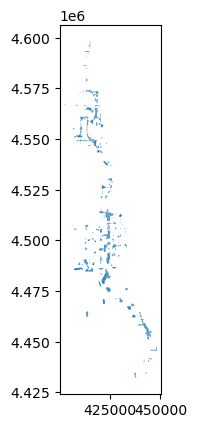

In [119]:
# Assuming gdf1, gdf2, and gdf3 are your GeoDataFrames

# Perform the intersection of the first two GeoDataFrames
gdf_centers_taz = gpd.overlay(gdf_filtered_centers, gdf_taz[['TAZID','TAZACRES','geometry','CO_FIPS']], how='intersection')

# Calculate the area in square meters
gdf_centers_taz['sqm'] = gdf_centers_taz.geometry.area

# Convert the area to acres
gdf_centers_taz['acres'] = gdf_centers_taz['sqm'] / 4046.85642

# The final_intersection GeoDataFrame now contains the intersection of all three GeoDataFrames
display(gdf_centers_taz)
gdf_centers_taz.plot()


# Get nearest stops

In [120]:
# Get transit line link data for projects

_df_transit_lin_files = pd.read_csv(os.path.join(input_model_line_files_folder, 'files.csv'))
_df_transit_lin_files_lines = pd.read_csv(os.path.join(input_model_line_files_folder, 'lines.csv'))
_df_transit_lin_files_links = pd.read_csv(os.path.join(input_model_line_files_folder, 'links.csv'))

_df_transit_lin_files_lines = pd.merge(_df_transit_lin_files, _df_transit_lin_files_lines, on=['file_index'])
_df_transit_lin_files_lines_links = pd.merge(_df_transit_lin_files_lines, _df_transit_lin_files_links, on=['file_index','name'])

_df_transit_lin_files_lines

if df_projects.empty:
    # Select unique model and name columns
    df_projects = _df_transit_lin_files_lines[['name']].drop_duplicates().reset_index(drop=True)
    
    # Create new index-based project_id starting from 1
    df_projects['project_id'] = df_projects.index + 1
    
    # Rename columns as specified
    df_projects.rename(columns={'name':'project_name'}, inplace=True)

    df_projects['tdm_line_name'] = df_projects['project_name']
    df_projects['tdm_model'] = tdm_model  # add field for joining later
    df_projects = df_projects[['project_id','project_name','tdm_model','tdm_line_name']]

df_project_transit_links = pd.merge(_df_transit_lin_files_lines_links, df_projects, left_on=['model','name'], right_on=['tdm_model','tdm_line_name'])
df_project_transit_links = df_project_transit_links[df_project_transit_links['transit_scenario']==tdm_transit_scenario]
df_project_transit_links = df_project_transit_links[['project_id','link_id']]
df_project_transit_links

,project_id,link_id
849,1,66822_63370
850,1,63370_63367
851,1,63367_63365
852,1,63365_63366
853,1,63366_66778
...,...,...
149443,150,21237_21241
149444,150,21241_21234
149445,150,21234_21275
149446,150,21275_21331


In [121]:
_df_transit_lin_files_nodes = pd.read_csv(os.path.join(input_model_line_files_folder, 'nodes.csv'))
_df_transit_lin_files_lines_nodes = pd.merge(_df_transit_lin_files_lines, _df_transit_lin_files_nodes, on=['file_index','name'])

df_project_transit_nodes = pd.merge(_df_transit_lin_files_lines_nodes, df_projects, left_on=['model','name'], right_on=['tdm_model','tdm_line_name'])
df_project_transit_nodes = df_project_transit_nodes[df_project_transit_nodes['transit_scenario']==tdm_transit_scenario]
df_project_transit_nodes = df_project_transit_nodes[df_project_transit_nodes['is_stop']==True]
df_project_transit_nodes = df_project_transit_nodes[['project_id','node_id','is_stop']]

df_project_transit_nodes

,project_id,node_id,is_stop
493,1,66822,True
517,1,66744,True
521,1,66770,True
526,1,66788,True
534,1,50024,True
...,...,...,...
104353,150,21088,True
104355,150,21022,True
104357,150,21031,True
104359,150,21028,True


In [59]:
# Read the shapefile
gdf_tdm_link = gpd.read_file(os.path.join(input_tdm_link_shapefile_folder, tdm_link_shapefile))

In [60]:
gdf_tdm_node = gpd.read_file(os.path.join(input_tdm_node_shapefile_folder, tdm_node_shapefile))

In [61]:
gdf_tdm_link.crs

<Projected CRS: EPSG:26912>
Name: NAD83 / UTM zone 12N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - between 114°W and 108°W - onshore and offshore. Canada - Alberta; Northwest Territories; Nunavut; Saskatchewan. United States (USA) - Arizona; Colorado; Idaho; Montana; New Mexico; Utah; Wyoming.
- bounds: (-114.0, 31.33, -108.0, 84.0)
Coordinate Operation:
- name: UTM zone 12N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<AxesSubplot:>

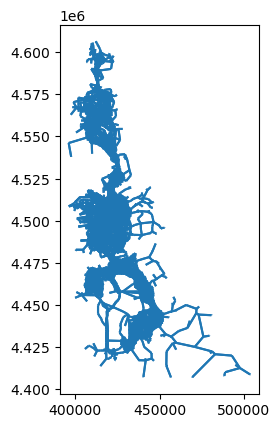

In [62]:
# display the gdf
gdf_tdm_link.plot()

<AxesSubplot:>

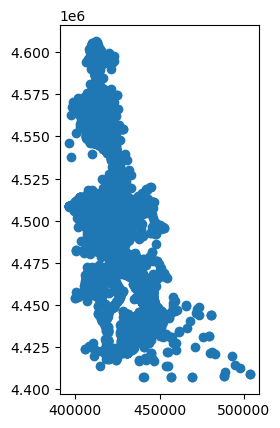

In [63]:
# display the gdf
gdf_tdm_node.plot()

In [64]:
# recalc link id because since it's not populated completely with changes.
gdf_tdm_link['LINKID'] = gdf_tdm_link['A'].astype(str) + '_' + gdf_tdm_link['B'].astype(str)

In [65]:
gdf_tdm_link = gdf_tdm_link[['A','B','LINKID','geometry']]
gdf_tdm_link

,A,B,LINKID,geometry
0,1,29685,1_29685,"LINESTRING (411935.000 4605642.000, 412478.126..."
1,2,29685,2_29685,"LINESTRING (412641.000 4606013.000, 412478.126..."
2,3,29645,3_29645,"LINESTRING (408993.000 4603544.000, 409632.415..."
3,4,29671,4_29671,"LINESTRING (410051.000 4604806.000, 409642.112..."
4,5,29680,5_29680,"LINESTRING (413394.000 4603600.000, 413482.000..."
...,...,...,...,...
57130,95064,95025,95064_95025,"LINESTRING (473181.550 4444171.200, 471782.100..."
57131,95064,95026,95064_95026,"LINESTRING (473181.550 4444171.200, 480751.220..."
57132,95064,95056,95064_95056,"LINESTRING (473181.550 4444171.200, 476015.900..."
57133,95065,3621,95065_3621,"LINESTRING (480730.710 4444037.000, 480767.876..."


In [66]:
df_project_transit_nodes

,project_id,node_id,is_stop
493,1,66822,True
517,1,66744,True
521,1,66770,True
526,1,66788,True
534,1,50024,True
...,...,...,...
104353,150,21088,True
104355,150,21022,True
104357,150,21031,True
104359,150,21028,True


In [67]:
df_project_transit_nodes

,project_id,node_id,is_stop
493,1,66822,True
517,1,66744,True
521,1,66770,True
526,1,66788,True
534,1,50024,True
...,...,...,...
104353,150,21088,True
104355,150,21022,True
104357,150,21031,True
104359,150,21028,True


,A,B,LINKID,geometry,project_id,link_id
0,10001,10002,10001_10002,"LINESTRING (421814.088 4477329.518, 421780.895...",20,10001_10002
1,10001,51010,10001_51010,"LINESTRING (421814.088 4477329.518, 421935.591...",20,10001_51010
2,10002,10001,10002_10001,"LINESTRING (421780.895 4478149.861, 421814.088...",20,10002_10001
3,10002,10003,10002_10003,"LINESTRING (421780.895 4478149.861, 420953.000...",20,10002_10003
4,10003,10002,10003_10002,"LINESTRING (420953.000 4479077.000, 421780.895...",20,10003_10002
...,...,...,...,...,...,...
10167,90129,90128,90129_90128,"LINESTRING (444031.300 4492478.500, 439471.500...",146,90129_90128
10168,90129,90130,90129_90130,"LINESTRING (444031.300 4492478.500, 445663.900...",146,90129_90130
10169,90130,90129,90130_90129,"LINESTRING (445663.900 4493357.700, 444031.300...",146,90130_90129
10170,90130,90131,90130_90131,"LINESTRING (445663.900 4493357.700, 448079.600...",146,90130_90131


,N,X,Y,GEOGKEY,EXTERNAL,HOTZN,TAZID,NODENAME,PNR_2015,PNR_2019,...,FARZN23_50,FARE23_32U,FARE23_42U,FARE23_50U,MAG_NODE,WFRC_NODE,geometry,project_id,node_id,is_stop
0,10008,423401.1517,4485422.991,423401_4485422,0,0,2117,Draper,40,80,...,11,11,11,11,0,1,POINT (423401.152 4485422.991),20,10008,True
1,10008,423401.1517,4485422.991,423401_4485422,0,0,2117,Draper,40,80,...,11,11,11,11,0,1,POINT (423401.152 4485422.991),95,10008,True
2,10008,423401.1517,4485422.991,423401_4485422,0,0,2117,Draper,40,80,...,11,11,11,11,0,1,POINT (423401.152 4485422.991),150,10008,True
3,10010,423760.0000,4490625.000,423760_4490625,0,255,1973,South Jordan,80,80,...,10,10,10,10,0,1,POINT (423760.000 4490625.000),20,10010,True
4,10010,423760.0000,4490625.000,423760_4490625,0,255,1973,South Jordan,80,80,...,10,10,10,10,0,1,POINT (423760.000 4490625.000),72,10010,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3193,90127,435243.9168,4491541.920,435243_4491541,0,0,2199,NaN,0,0,...,0,0,0,0,0,1,POINT (435243.917 4491541.920),146,90127,True
3194,90128,439471.5000,4491402.100,439471_4491402,0,0,2198,NaN,0,0,...,0,0,0,0,0,1,POINT (439471.500 4491402.100),146,90128,True
3195,90129,444031.3000,4492478.500,444031_4492478,0,0,2197,NaN,0,0,...,0,0,0,0,0,1,POINT (444031.300 4492478.500),146,90129,True
3196,90130,445663.9000,4493357.700,445663_4493357,0,0,2196,NaN,0,0,...,0,0,0,0,0,1,POINT (445663.900 4493357.700),146,90130,True


<AxesSubplot:>

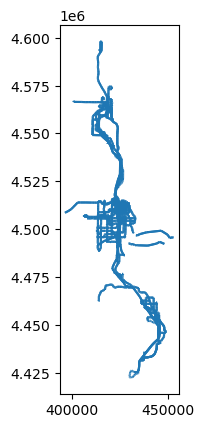

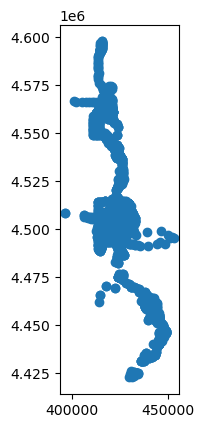

In [122]:
gdf_tdm_link_with_projects = pd.merge(gdf_tdm_link, df_project_transit_links, left_on='LINKID', right_on='link_id')
display(gdf_tdm_link_with_projects)
gdf_tdm_link_with_projects.plot()

gdf_tdm_node_with_projects = pd.merge(gdf_tdm_node, df_project_transit_nodes, left_on='N', right_on='node_id')
display(gdf_tdm_node_with_projects)
gdf_tdm_node_with_projects.plot()

,OBJECTID,AreaName,AreaType,Area,Shape__Area,Shape__Length,TAZID_center,TAZACRES,CO_FIPS,geometry_center,...,FARZN23_50,FARE23_32U,FARE23_42U,FARE23_50U,MAG_NODE,WFRC_NODE,geometry_node,project_id,node_id,is_stop
0,35,Crossroads,City Center,Utah County,3.847764e+06,8225.990373,2496,165.490872,49,"POLYGON ((421958.924 4468475.185, 421704.024 4...",...,0,0,0,0,1,0,POINT (422206.337 4469536.370),134,62317,True
1,35,Crossroads,City Center,Utah County,3.847764e+06,8225.990373,2503,85.734122,49,"POLYGON ((422468.715 4468706.905, 422213.825 4...",...,0,0,0,0,1,0,POINT (422206.337 4469536.370),134,62317,True
2,35,Crossroads,City Center,Utah County,3.847764e+06,8225.990373,2504,146.410140,49,"POLYGON ((422640.942 4469115.927, 422641.047 4...",...,0,0,0,0,1,0,POINT (422206.337 4469536.370),134,62317,True
3,35,Crossroads,City Center,Utah County,3.847764e+06,8225.990373,2505,76.823967,49,"POLYGON ((422654.105 4469147.185, 422649.306 4...",...,0,0,0,0,1,0,POINT (422206.337 4469536.370),134,62317,True
4,35,Crossroads,City Center,Utah County,3.847764e+06,8225.990373,2498,112.631810,49,"POLYGON ((421588.154 4469911.650, 421669.151 4...",...,0,0,0,0,1,0,POINT (422206.337 4469536.370),134,62317,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1242,515,Meadowbrook Station,City Center,WFRC MPO,2.623103e+06,8153.372722,1492,45.728115,35,"POLYGON ((424235.616 4505014.079, 424269.116 4...",...,0,0,0,0,0,1,POINT (424461.195 4504396.307),64,24228,True
1243,515,Meadowbrook Station,City Center,WFRC MPO,2.623103e+06,8153.372722,1493,50.633831,35,"MULTIPOLYGON (((424462.516 4504848.479, 424705...",...,0,0,0,0,0,1,POINT (424461.195 4504396.307),64,24228,True
1244,515,Meadowbrook Station,City Center,WFRC MPO,2.623103e+06,8153.372722,1494,50.381448,35,"POLYGON ((424715.708 4504846.582, 424945.987 4...",...,0,0,0,0,0,1,POINT (424702.330 4504394.731),64,24256,True
1245,515,Meadowbrook Station,City Center,WFRC MPO,2.623103e+06,8153.372722,1495,88.369280,35,"POLYGON ((424961.771 4504845.920, 424963.041 4...",...,0,0,0,0,0,1,POINT (424947.000 4504397.000),64,24281,True


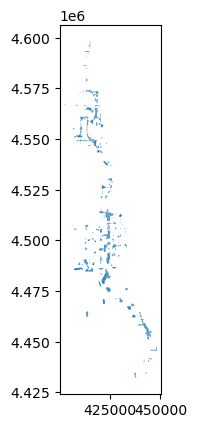

In [123]:
from shapely.ops import nearest_points
import geopandas as gpd

# Create a copy to work with
_df = gdf_centers_taz.copy()

# Reproject to a projected coordinate system for accurate distance calculation (e.g., EPSG:26912 for Utah)
_df = _df.to_crs("EPSG:26912")
gdf_tdm_node_with_projects = gdf_tdm_node_with_projects.to_crs("EPSG:26912")

# Define a function to find the index of the nearest point in gdf_tdm_node_with_projects
def find_nearest_index(polygon, points):
    # Calculate distances to each point in points and get the index of the nearest
    distances = points.distance(polygon)
    nearest_index = distances.idxmin()
    return nearest_index

# Apply the function to get the index of the nearest point for each polygon
_df['nearest_point_index'] = _df['geometry'].apply(lambda geom: find_nearest_index(geom, gdf_tdm_node_with_projects))

# Calculate the nearest point geometry and distance in miles
_df['nearest_point'] = _df['nearest_point_index'].apply(lambda idx: gdf_tdm_node_with_projects.loc[idx].geometry)
_df['distance_to_nearest_miles'] = _df.apply(
    lambda row: row['geometry'].distance(row['nearest_point']) * 0.000621371,  # Convert meters to miles
    axis=1
)

# Now, merge the data using the nearest point index
gdf_centers_taz_stops = _df.merge(
    gdf_tdm_node_with_projects, 
    left_on='nearest_point_index', 
    right_index=True, 
    how='left',  # Ensures all polygons in _df are retained
    suffixes=('_center', '_node')
)

# Reassign 'geometry_center' as the active geometry in gdf_centers_taz_stops
gdf_centers_taz_stops = gpd.GeoDataFrame(gdf_centers_taz_stops, geometry='geometry_center')

# Verify that 'geometry_center' is now the active geometry
gdf_centers_taz_stops.plot()
gdf_centers_taz_stops

In [124]:
# Filter the dataset for unmatched polygons where values from gdf_tdm_node_with_projects are NaN
unmatched_gdf = gdf_centers_taz_stops[gdf_centers_taz_stops['nearest_point_index'].isna()]

# Display or work with the unmatched dataset
unmatched_gdf


,OBJECTID,AreaName,AreaType,Area,Shape__Area,Shape__Length,TAZID_center,TAZACRES,CO_FIPS,geometry_center,...,FARZN23_50,FARE23_32U,FARE23_42U,FARE23_50U,MAG_NODE,WFRC_NODE,geometry_node,project_id,node_id,is_stop


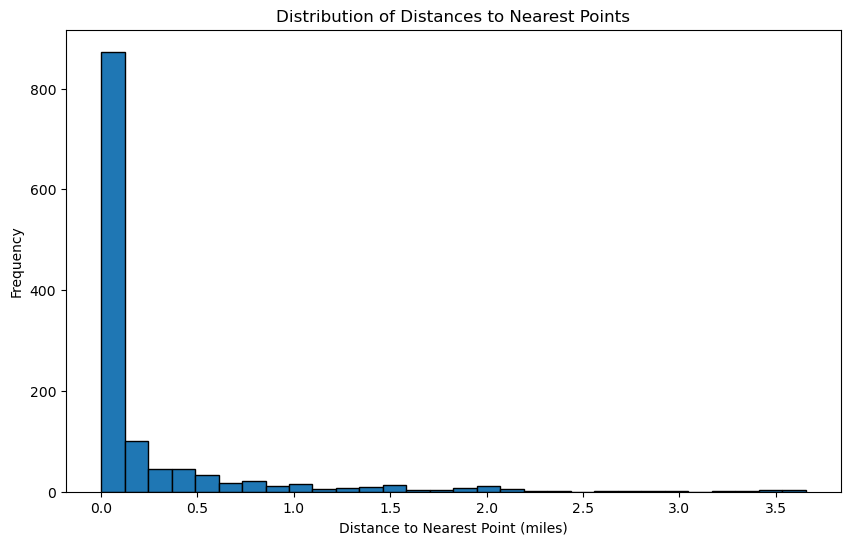

count    1247.000000
mean        0.234584
std         0.534757
min         0.000000
25%         0.000000
50%         0.002644
75%         0.173479
max         3.655861
Name: distance_to_nearest_miles, dtype: float64

In [125]:
import matplotlib.pyplot as plt

# Filter out NaN values to focus only on matched distances
matched_distances = gdf_centers_taz_stops['distance_to_nearest_miles'].dropna()

# Plot histogram to show distribution of distances
plt.figure(figsize=(10, 6))
plt.hist(matched_distances, bins=30, edgecolor='black')
plt.xlabel("Distance to Nearest Point (miles)")
plt.ylabel("Frequency")
plt.title("Distribution of Distances to Nearest Points")
plt.show()

# Optionally, display descriptive statistics for distance distribution
distance_stats = matched_distances.describe()
distance_stats


,N,project_id,AreaName,AreaType,TAZID,TAZACRES,CO_FIPS,geometry,sqm,acres
0,62317,134,Crossroads,City Center,2496,165.490872,49,"POLYGON ((421958.924 4468475.185, 421704.024 4...",306078.979084,75.633763
1,62317,134,Crossroads,City Center,2503,85.734122,49,"POLYGON ((422468.715 4468706.905, 422213.825 4...",185231.805669,45.771776
2,62317,134,Crossroads,City Center,2504,146.410140,49,"POLYGON ((422640.942 4469115.927, 422641.047 4...",82.317025,0.020341
3,62317,134,Crossroads,City Center,2505,76.823967,49,"POLYGON ((422654.105 4469147.185, 422649.306 4...",167718.011467,41.444023
4,62317,134,Crossroads,City Center,2498,112.631810,49,"POLYGON ((421588.154 4469911.650, 421669.151 4...",268457.440292,66.337278
...,...,...,...,...,...,...,...,...,...,...
1242,24228,64,Meadowbrook Station,City Center,1492,45.728115,35,"POLYGON ((424235.616 4505014.079, 424269.116 4...",149005.282516,36.820007
1243,24228,64,Meadowbrook Station,City Center,1493,50.633831,35,"MULTIPOLYGON (((424462.516 4504848.479, 424705...",109626.735660,27.089356
1244,24256,64,Meadowbrook Station,City Center,1494,50.381448,35,"POLYGON ((424715.708 4504846.582, 424945.987 4...",108708.827297,26.862536
1245,24281,64,Meadowbrook Station,City Center,1495,88.369280,35,"POLYGON ((424961.771 4504845.920, 424963.041 4...",93800.997173,23.178731


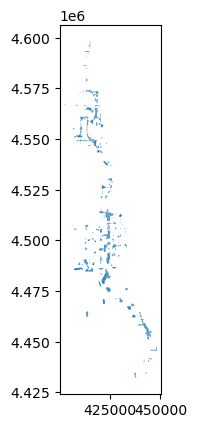

In [126]:
#gdf_buffered_stops_with_centers_taz.fillna(0, inplace=True)
_gdf = gdf_centers_taz_stops.copy()
_gdf.rename(columns={'TAZID_center':'TAZID','geometry_center':'geometry'}, inplace=True)
_gdf = gpd.GeoDataFrame(_gdf, geometry='geometry')
_gdf['N'] = _gdf['N'].astype(int)
_gdf['project_id'] = _gdf['project_id'].astype(int)
_gdf = _gdf[['N','project_id','AreaName','AreaType','TAZID','TAZACRES','CO_FIPS','geometry','sqm','acres']]
_gdf.plot()
centers_taz_with_nearest_stop_gdf = _gdf
centers_taz_with_nearest_stop_gdf

In [127]:
centers_taz_with_nearest_stop_gdf.to_file("intermediate/centers-taz-with-nearest-stop.geojson", format='geojson')
print('Exported')

Exported


In [117]:
gdf_taz_export = gdf_taz[['TAZID','geometry']]
gdf_taz_export = gdf_taz_export.to_crs(epsg=4326)
gdf_taz_export.to_file('_site/data/taz.geojson')


In [118]:
gdf_wc_centers_export = gdf_filtered_centers
gdf_wc_centers_export = gdf_wc_centers_export.to_crs(epsg=4326)
gdf_wc_centers_export.to_file('_site/data/wc_centers.geojson')